In [165]:
import pandas as pd
import numpy as np
import datetime
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

#ML imports
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

# Data Source

We use tha data source outputed from the timeseries pre processing done in this notebook (https://www.kaggle.com/joaquinruisenor/timeseries-prophet). We input a univariate timeseries data of the power consumption of the PJME grid in the USA.

PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).
.

In [150]:
df_gb = pd.read_csv('../input/timeseries-prophet/Energy_PJM.csv')

In [151]:
df_gb.head()

,Datetime,Energy
0,2002-12-31 01:00:00,31575.0
1,2002-12-31 02:00:00,30086.0
2,2002-12-31 03:00:00,29459.0
3,2002-12-31 04:00:00,29250.0
4,2002-12-31 05:00:00,29790.0


## The Project

In this instance of timeseries forecasting we are going to perform a Gradient Boosted Decision Tree model using the `xgboost` library. We are again, not leveraging the timeseries aspect of the data, all the details of the timeseries project can be seen in the Timeseries forecasting with prophet (https://www.kaggle.com/joaquinruisenor/timeseries-prophet) where we explain the whole project.

We need to add time features to our data set so we can train the model on those and see if the target value, which is going to be (hourly energy consumption) is predicted accuratley.

In [152]:
def create_features(df_split, label=None): 
    df_split = df_split.reset_index()
    df_split['Datetime'] =  pd.to_datetime(df_split['Datetime'], infer_datetime_format=True)
    df_split['hour'] = df_split['Datetime'].dt.hour
    df_split['dayofweek'] = df_split['Datetime'].dt.dayofweek
    df_split['quarter'] = df_split['Datetime'].dt.quarter
    df_split['month'] = df_split['Datetime'].dt.month
    df_split['year'] = df_split['Datetime'].dt.year
    df_split['dayofyear'] = df_split['Datetime'].dt.dayofyear
    df_split['dayofmonth'] = df_split['Datetime'].dt.day
    df_split['weekofyear'] = df_split['Datetime'].dt.weekofyear
    
    X = df_split[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df_split[label]
        return X, y
    X = X.drop(label, axis=1, inplace=True)
    return X

In [153]:
#We split the data into training and testing set
df_gb.set_index('Datetime', inplace = True)
split_date = '2017-01-01'
df_train = df_gb.loc[df_gb.index <= split_date].copy()
df_test = df_gb.loc[df_gb.index > split_date].copy()

In [154]:
x_train, y_train = create_features(df_train, label='Energy')
x_test, y_test = create_features(df_test, label='Energy')

After we split the dataset into training and testing set we go ahead and perform the regression. One of the many advantages of using decision tress is the fact that we dont need variable rescaling. One thing that could help is adding polynomial variables to imporve the accuracy. 

We are going to do the regression on theunivariate series first.

In [157]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:27104.31445	validation_1-rmse:26027.77539
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:19183.91211	validation_1-rmse:18156.18945
[2]	validation_0-rmse:13709.87891	validation_1-rmse:12800.51856
[3]	validation_0-rmse:9965.10547	validation_1-rmse:9240.29883
[4]	validation_0-rmse:7468.35693	validation_1-rmse:6983.87695
[5]	validation_0-rmse:5812.61279	validation_1-rmse:5641.70312
[6]	validation_0-rmse:4791.12402	validation_1-rmse:4920.23096
[7]	validation_0-rmse:4159.48242	validation_1-rmse:4668.25781
[8]	validation_0-rmse:3816.58179	validation_1-rmse:4490.81934
[9]	validation_0-rmse:3609.81665	validation_1-rmse:4429.12012
[10]	validation_0-rmse:3474.98975	validation_1-rmse:4403.67041
[11]	validation_0-rmse:3385.01880	validation_1-rmse:4442.41602
[12]	validation_0-rmse:3293.07739	validation_1-rmse:4521.22607
[13]	validation_0-rmse:326

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

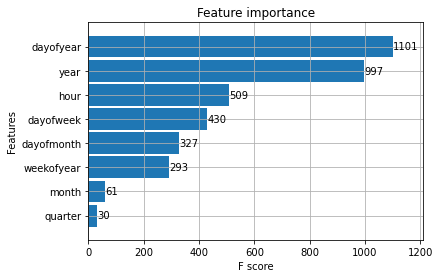

In [158]:
_ = plot_importance(reg, height=0.9)

In [160]:
df_test['Energy Prediction'] = reg.predict(x_test) #this predicts the values of energy using de X_test data and puts
#it into a new column in df_test
predictions = [round(value) for value in df_test['Energy Prediction']]
df_all = pd.concat([df_test, df_train], sort=False)

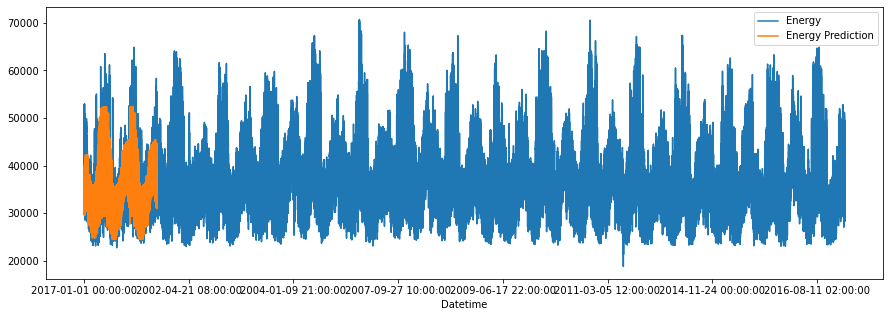

In [161]:
_ = df_all[['Energy','Energy Prediction']].plot(figsize=(15, 5))

We see the plot of the prediction and the actual data for the test dataset.

## Error measurement

In machine learning models its common to calculate Root Mean Squared error (RMSE) for the testing data and the training data to check for overfitting.

In [162]:
y_prediction_on_train = reg.predict(x_train)
y_prediction_on_test = reg.predict(x_test)

In [163]:
MSE_Train = mean_squared_error(y_train,y_prediction_on_train )
MSE_Test = mean_squared_error(y_test,y_prediction_on_test )
RMSE_Train = sqrt(MSE_Train)
RMSE_Test = sqrt(MSE_Test)

In [164]:
print('RMSE_Train: '+ str(RMSE_Train))
print('RMSE_Test: '+ str(RMSE_Test))

RMSE_Train: 3474.9948882997132
RMSE_Test: 4403.670412472608


We can see that the model has a much better performance on the training set, this lead to conclusion that the model is overfitted. Still the prediction accuracy is inferior the autoregressive (AR) model in past notebook (https://www.kaggle.com/joaquinruisenor/timeseries-arima).


## Regularization 

We are going to perform regularization of the Gradient Boosted Regression tree model, we are going to achieve the parameter tuning by using the function `RandomizedSearchCV()`

In [166]:
## Hyper Parameter Optimization
base_score=[0.25,0.5,0.75,1]
n_estimators = [900, 1100, 1500] #the number of decision trees it can have
max_depth = [2, 3, 5] #the nr of depthd of the trees
booster=['gbtree'] #probably will choose gbtree but we give it the choice either way to choose a linear regression
learning_rate=[0.05,0.1,0.15,0.20] #values for different learning rates
min_child_weight=[2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

#Remember all these hyperparameters are used inside XGBoost Regressor, othr wise it wont be able to use them, see with
#the Shift+tab

In [167]:
# Set up the random search with 4-fold cross validation usinv CV=5
random_cv = RandomizedSearchCV(estimator=reg,
            param_distributions=hyperparameter_grid, #we use the grid we defined before
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True, #getting the training score
            random_state=42)

In [169]:
random_cv.fit(x_train,y_train) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 26.2min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 60.6min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 102.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster=None,
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=1000, n...
                                          verbosity=None),
                   iid='deprecated', n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 

In [170]:
random_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_delta_step=0, max_depth=3,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=1100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

These are the chosen parameters of our `RandomSearchCV()` that minimize the RMSE. Now we are going to input these values to the regressor.
We can see the optimized parameter valus after performing the Randomized Search function which took more than 100 minutes. We will copy this values and insert it in the next iteration of the XGBReegressor. The advantages of using the xgboost library over the sklearn GradientBoosted Regressor is that it allows heavy Hyperparameter tuning which is key to Gradient Boosted Trees, not so much for Random Forrest where if preferable to use the sklearn libraries

In [174]:
import xgboost
from numpy import nan
regressor=xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_delta_step=0, max_depth=3,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=1100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)
#inserted values into the initialization of the Algo

regressor.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:30972.56445	validation_1-rmse:29810.31250
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:24951.53711	validation_1-rmse:23788.45508
[2]	validation_0-rmse:20203.67578	validation_1-rmse:19085.76758
[3]	validation_0-rmse:16418.81641	validation_1-rmse:15337.49023
[4]	validation_0-rmse:13462.80273	validation_1-rmse:12404.65820
[5]	validation_0-rmse:11102.52051	validation_1-rmse:10106.15332
[6]	validation_0-rmse:9273.06445	validation_1-rmse:8360.64648
[7]	validation_0-rmse:7896.35547	validation_1-rmse:7092.02783
[8]	validation_0-rmse:6831.38281	validation_1-rmse:6147.45459
[9]	validation_0-rmse:6061.28369	validation_1-rmse:5526.26465
[10]	validation_0-rmse:5473.63818	validation_1-rmse:5100.01416
[11]	validation_0-rmse:5071.13867	validation_1-rmse:4890.43750
[12]	validation_0-rmse:4711.92578	validation_1-rmse:4663.17236
[13]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_delta_step=0, max_depth=3,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=1100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [175]:
df_test['Energy Prediction Regularized'] = regressor.predict(x_test) #this predicts the values of energy using de X_test data and puts
#it into a new column in df_test
predictions = [round(value) for value in df_test['Energy Prediction Regularized']]
df_all_reg = pd.concat([df_test, df_train], sort=False)

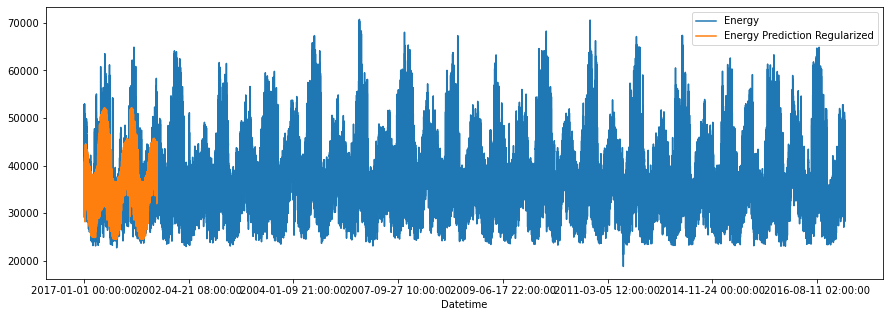

In [176]:
pl = df_all_reg[['Energy','Energy Prediction Regularized']].plot(figsize=(15, 5))

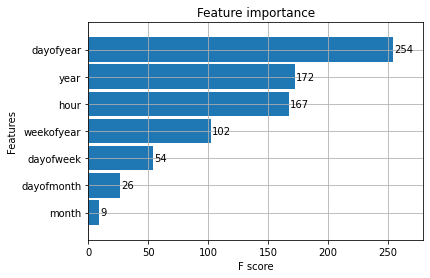

In [178]:
t = plot_importance(regressor, height=0.9)

We see a change in the feature importances, before the regularizationthere was 8 enlisted features and now we have 7 with less magnitude of F-Score.

## Error Measurement after Regularization

In [179]:
y_prediction_on_train_reg = regressor.predict(x_train)
y_prediction_on_test_reg = regressor.predict(x_test)

In [180]:
MSE_Train_reg = mean_squared_error(y_train,y_prediction_on_train_reg )
MSE_Test_reg = mean_squared_error(y_test,y_prediction_on_test_reg )
RMSE_Train_reg = sqrt(MSE_Train_reg)
RMSE_Test_reg = sqrt(MSE_Test_reg)

In [181]:
print('RMSE_Train: '+ str(RMSE_Train_reg))
print('RMSE_Test: '+ str(RMSE_Test_reg))

RMSE_Train: 3476.326664025585
RMSE_Test: 4490.498171199467


| Model          | RMSE Train   | RMSE Test    |
| :------------- | :----------: | -----------: |
|  Before Reg    | 3474.9948    | 4403.6704    |
|  After Reg     | 3476.3266    | 4490.4981    |

We can see that the choice of parameters in the first round (before regularization) yielded, weirdly enough, a better performance over the testing and training set.

In [182]:
import xgboost
from numpy import nan
prueba=xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.5, max_delta_step=0, max_depth=5,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=1100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)
#inserted values into the initialization of the Algo

prueba.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:19611.87695	validation_1-rmse:18488.70703
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:10460.63867	validation_1-rmse:9518.74316
[2]	validation_0-rmse:6208.29834	validation_1-rmse:5809.39258
[3]	validation_0-rmse:4532.99951	validation_1-rmse:4667.12598
[4]	validation_0-rmse:3883.03394	validation_1-rmse:4729.73877
[5]	validation_0-rmse:3662.46948	validation_1-rmse:4717.90674
[6]	validation_0-rmse:3591.64770	validation_1-rmse:4745.70068
[7]	validation_0-rmse:3465.45947	validation_1-rmse:4820.76465
[8]	validation_0-rmse:3403.85254	validation_1-rmse:4859.27002
[9]	validation_0-rmse:3381.59375	validation_1-rmse:4858.84863
[10]	validation_0-rmse:3286.91138	validation_1-rmse:4886.56836
[11]	validation_0-rmse:3266.44971	validation_1-rmse:4901.79102
[12]	validation_0-rmse:3237.50464	validation_1-rmse:4927.86182
[13]	validation_0-rmse:3175.0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.5, max_delta_step=0, max_depth=5,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=1100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In this last run, we wanted to elevate the paramaters that where chosen within the extremes of what we presented as possibilities inside the `RandomSearchCV()`, this was the case of the learning rate (chosen 0.2 so it was tunned here with 0.3) and the max_depth (chosen was 3 and now was runned with 5).

We wanted to discard that the model performance was bounded by the arbitrary election we gave as inputs to the Random Search of parameters. We can see that after changin these 2 parameters as mentiones, the RMSE was bigger than previous regularized iteration and the first iteration which was the best of tthe 3.

## Plotting prediction



In [184]:
df_test.head()

,Energy,Energy Prediction,Energy Prediction Regularized
Datetime,,,
2017-01-01 00:00:00,33402.0,30061.025391,32962.019531
2017-12-31 01:00:00,42148.0,31792.759766,31350.158203
2017-12-31 02:00:00,41268.0,30077.341797,29982.988281
2017-12-31 03:00:00,41003.0,29610.474609,29138.363281
2017-12-31 04:00:00,41123.0,29610.474609,29138.363281


In [ ]:
df_test.dtypes

(736330.0, 736695.0)

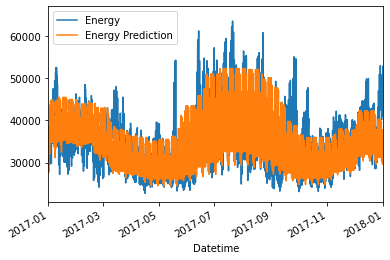

In [216]:
c = df_test.reset_index()
c['Datetime'] =  pd.to_datetime(c['Datetime'], infer_datetime_format=True)
c[["Datetime", "Energy", "Energy Prediction"]].plot(x="Datetime", kind="line")
plt.xlim(datetime.date(2017,1,1), datetime.date(2018,1,1))

(736664.0, 736694.0)

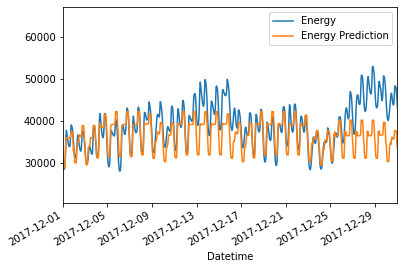

In [217]:

c = df_test.reset_index()
c['Datetime'] =  pd.to_datetime(c['Datetime'], infer_datetime_format=True)
c[["Datetime", "Energy", "Energy Prediction"]].plot(x="Datetime", kind="line")
plt.xlim(datetime.date(2017,12,1), datetime.date(2017,12,31))

Here we see the forecasted values of the Regressor Tree for 2017 and for the month of December of that year. We can see the errors compared to the forecast made by prophet (https://www.kaggle.com/joaquinruisenor/timeseries-prophet)